# Market Basket Analysis 101 with Real Example

### Association rules, Lift, Confidence, Support

## Table of Content
1. Introduction
2. What is Market Basket Analysis?
3. Import Library / Data
4. Data pre-processing
5. Association Rules in Python
6. Deriving Association Rules
7. Findings / Conclusion

## 1.0 Introduction

Another exciting topic in marketing analytics is Market Basket Analysis. This is the topic of this publication. At the beginning of this post I will be introducing some key terms and metrics aimed at giving a sense of what “association” in a rule means and some ways to quantify the strength of this association. Then I will show how to generate these rules from the dataset ‘Online Retail’ using the Apriori Algorithm.

For this post the dataset Online Retail from the statistic platform “Kaggle” was used. You can download it from my “GitHub Repository”.

## 2.0 What is Market Basket Analysis?

Market Basket Analysis is a analysis technique which identifies the strength of association between pairs of products purchased together and identify patterns of co-occurrence.

Market Basket Analysis creates If-Then scenario rules (association rules), for example, if item A is purchased then item B is likely to be purchased. The rules are probabilistic in nature or, in other words, they are derived from the frequencies of co-occurrence in the observations. Frequency is the proportion of baskets that contain the items of interest. The rules can be used in pricing strategies, product placement, and various types of cross-selling strategies.

How association rules work

Association rule mining, at a basic level, involves the use of machine learning models to analyze data for patterns, or co-occurrences, in a database. It identifies frequent if-then associations, which themselves are the association rules.

An association rule has two parts: an antecedent (if) and a consequent (then). An antecedent is an item found within the data. A consequent is an item found in combination with the antecedent.

Association rules are created by searching data for frequent if-then patterns and using the criteria support and confidence to identify the most important relationships. Support is an indication of how frequently the items appear in the data. Confidence indicates the number of times the if-then statements are found true. A third metric, called lift, can be used to compare confidence with expected confidence, or how many times an if-then statement is expected to be found true.

Association rules are calculated from itemsets, which are made up of two or more items. If rules are built from analyzing all the possible itemsets, there could be so many rules that the rules hold little meaning. With that, association rules are typically created from rules well-represented in data.

More about association rule can be found on https://michael-fuchs-python.netlify.app/2020/09/15/marketing-market-basket-analysis/

# 3.0 Dive into code - Import Libraries / Data

In [9]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import mlxtend.preprocessing
import mlxtend.frequent_patterns

In [14]:
df = pd.read_excel("./data/Retail.xlsx", sheet_name="Online Retail")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [15]:
df.shape

(541909, 8)

In [16]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# 4.0 Preprocess the dataset

In [17]:
'''
Create an indicator column stipulating whether the invoice number begins with 'C'
'''

df['Is_C_Present'] = (
    df['InvoiceNo']
    .astype(str)
    .apply(lambda x: 1 if x.find('C') != -1 else 0))

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Is_C_Present
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0


In [10]:
df.Is_C_Present.value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         0
2         0
3         0
4         0
         ..
541904    0
541905    0
541906    0
541907    0
541908    0
Name: Is_C_Present, Length: 541909, dtype: int64>

In [18]:
'''
Filter out all transactions having either zero or a negative number of items.
Remove all invoice numbers starting with 'C' (using columns 'Is_C_Present').
Subset the dataframe down to 'InvoiceNo' and 'Descritpion'.
Drop all rows with at least one missing value.
'''


df_clean = (
    df
    # filter out non-positive quantity values
    .loc[df["Quantity"] > 0]
    # remove InvoiceNos starting with C
    .loc[df['Is_C_Present'] != 1]
    # column filtering
    .loc[:, ["InvoiceNo", "Description"]]
    # dropping all rows with at least one missing value
    .dropna()
)

df_clean

,InvoiceNo,Description
0,536365,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,WHITE METAL LANTERN
2,536365,CREAM CUPID HEARTS COAT HANGER
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,RED WOOLLY HOTTIE WHITE HEART.
...,...,...
541904,581587,PACK OF 20 SPACEBOY NAPKINS
541905,581587,CHILDREN'S APRON DOLLY GIRL
541906,581587,CHILDRENS CUTLERY DOLLY GIRL
541907,581587,CHILDRENS CUTLERY CIRCUS PARADE


In [19]:
'''
Transform the data into a list of lists called invoice_item_list

'''

invoice_item_list = []

for num in list(set(df_clean.InvoiceNo.tolist())):
    # filter data set down to one invoice number
    tmp_df = df_clean.loc[df_clean['InvoiceNo'] == num]
    # extract item descriptions and convert to list
    tmp_items = tmp_df.Description.tolist()
    # append list invoice_item_list
    invoice_item_list.append(tmp_items)

print(invoice_item_list[1:3])

[['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'], ['ASSORTED COLOUR BIRD ORNAMENT', "POPPY'S PLAYHOUSE BEDROOM ", "POPPY'S PLAYHOUSE KITCHEN", 'FELTCRAFT PRINCESS CHARLOTTE DOLL', 'IVORY KNITTED MUG COSY ', 'BOX OF 6 ASSORTED COLOUR TEASPOONS', 'BOX OF VINTAGE JIGSAW BLOCKS ', 'BOX OF VINTAGE ALPHABET BLOCKS', 'HOME BUILDING BLOCK WORD', 'LOVE BUILDING BLOCK WORD', 'RECIPE BOX WITH METAL HEART', 'DOORMAT NEW ENGLAND']]


To be able to run any models the data, currently in the list of lists form, needs to be encoded and recast as a dataframe. 

Outputted from the encoder is a multidimensional array, where each row is the length of the total number of unique items in the transaction dataset and the elements are Boolean variables, indicating whether that particular item is linked to the invoice number that row presents. 

With the data encoded, we can recast it as a dataframe where the rows are the invoice numbers and the columns are the unique items in the transaction dataset.

In [20]:
# Initialize and fit the transaction encoder
online_encoder = mlxtend.preprocessing.TransactionEncoder()
online_encoder_array = online_encoder.fit_transform(invoice_item_list)

# Recast the encoded array as a dataframe
online_encoder_df = pd.DataFrame(online_encoder_array, columns=online_encoder.columns_)

# Print the results
online_encoder_df

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20131,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20132,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20133,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
20134,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# 5.0 Association Rules

The Apriori algorithm is one of the most common techniques in Market Basket Analysis to find the association between events

It is used to analyze the frequent itemsets in a transactional database, which then is used to generate association rules between the products.

In [21]:
'''
Run the Apriori Algorithm with min_support = 0.01 (by default 0.5)
'''

apriori_model = mlxtend.frequent_patterns.apriori(online_encoder_df, min_support=0.01)
apriori_model

,support,itemsets
0,0.013359,(8)
1,0.015793,(14)
2,0.012465,(20)
3,0.017630,(21)
4,0.017978,(22)
...,...,...
1849,0.011025,"(1840, 1827, 1837, 1838)"
1850,0.011174,"(2010, 2015, 2014, 2007)"
1851,0.010280,"(2010, 2015, 2020, 2007)"
1852,0.010181,"(2015, 2020, 2014, 2007)"


In [22]:
'''
Run the same model again, but this time with use_colnames=True.
This will replace the numerical designations with the actual item names.
'''

apriori_model_colnames = mlxtend.frequent_patterns.apriori(
    online_encoder_df, 
    min_support=0.01,
    use_colnames=True
)

apriori_model_colnames

,support,itemsets
0,0.013359,( SET 2 TEA TOWELS I LOVE LONDON )
1,0.015793,(10 COLOUR SPACEBOY PEN)
2,0.012465,(12 MESSAGE CARDS WITH ENVELOPES)
3,0.017630,(12 PENCIL SMALL TUBE WOODLAND)
4,0.017978,(12 PENCILS SMALL TUBE RED RETROSPOT)
...,...,...
1849,0.011025,"(JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG..."
1850,0.011174,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU..."
1851,0.010280,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU..."
1852,0.010181,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA..."


In [23]:
'''
Add an additional column to the output of apriori_model_colnames that contains the size of the item set.
This will help with filtering and further analysis. 
'''

apriori_model_colnames['length'] = (
    apriori_model_colnames['itemsets'].apply(lambda x: len(x))
)

apriori_model_colnames

,support,itemsets,length
0,0.013359,( SET 2 TEA TOWELS I LOVE LONDON ),1
1,0.015793,(10 COLOUR SPACEBOY PEN),1
2,0.012465,(12 MESSAGE CARDS WITH ENVELOPES),1
3,0.017630,(12 PENCIL SMALL TUBE WOODLAND),1
4,0.017978,(12 PENCILS SMALL TUBE RED RETROSPOT),1
...,...,...,...
1849,0.011025,"(JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...",4
1850,0.011174,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU...",4
1851,0.010280,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU...",4
1852,0.010181,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...",4


#### Examine one case

In [24]:
apriori_model_colnames[
    apriori_model_colnames['itemsets'] == frozenset(
        {'12 PENCIL SMALL TUBE WOODLAND'})]

,support,itemsets,length
3,0.01763,(12 PENCIL SMALL TUBE WOODLAND),1


The output gives us the support value for ‘12 PENCIL SMALL TUBE WOODLAND’. The support value says that this specific item appears in 1,76% of the transactions.

In [25]:
apriori_model_colnames[
    (apriori_model_colnames['length'] == 2) & 
    (apriori_model_colnames['support'] >= 0.02) &
    (apriori_model_colnames['support'] < 0.021)
]

,support,itemsets,length
836,0.020759,"(ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELI...",2
887,0.020362,"(CHARLOTTE BAG SUKI DESIGN, CHARLOTTE BAG PINK...",2
923,0.020610,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...",2
1105,0.020560,"(JUMBO BAG BAROQUE BLACK WHITE, JUMBO BAG PIN...",2
1114,0.020908,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG...",2
1116,0.020957,"(JUMBO BAG BAROQUE BLACK WHITE, JUMBO STORAGE...",2
1129,0.020560,"(JUMBO BAG RED RETROSPOT, JUMBO BAG ALPHABET)",2
1137,0.020163,"(JUMBO BAG APPLES, JUMBO BAG PEARS)",2
1203,0.020709,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",2
1218,0.020560,"(JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SK...",2


### This dataframe contains all the item sets (pairs of items bought together) whose support value is in the range between 2% and 2.1% of transactions.

### When you are filtering on support, it is important to specify a range instead of a sprecific value since it is quite possible to pick a value for which there are no item sets.

Text(0.5, 1.0, 'Support')

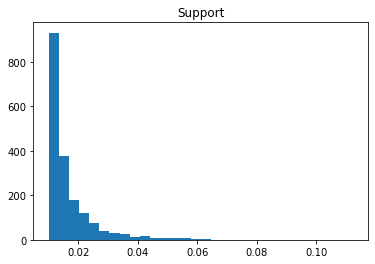

In [26]:
apriori_model_colnames.hist("support", grid=False, bins=30)
plt.title("Support")

# 4.0 Deriving Association Rules

In [27]:
'''
Generate derive association rules for the online retail dataset.
Here we use confidence as the measure of interestingness.
Set the minimum threshold to 0.6.
Return all metrics, not just support.
'''

rules = mlxtend.frequent_patterns.association_rules(
    apriori_model_colnames, 
    metric="confidence",
    min_threshold=0.6, 
    support_only=False
)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.021255,0.048669,0.013756,0.647196,13.297902,0.012722,2.696488
1,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED ),0.021255,0.052195,0.014501,0.682243,13.071023,0.013392,2.982798
2,(ALARM CLOCK BAKELIKE ORANGE),(ALARM CLOCK BAKELIKE GREEN),0.022100,0.048669,0.013558,0.613483,12.605201,0.012482,2.461292
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.048669,0.052195,0.031784,0.653061,12.511932,0.029244,2.731908
4,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.052195,0.048669,0.031784,0.608944,12.511932,0.029244,2.432722
...,...,...,...,...,...,...,...,...,...
493,"(CHARLOTTE BAG SUKI DESIGN, RED RETROSPOT CHAR...","(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...",0.016339,0.020163,0.010131,0.620061,30.752572,0.009802,2.578931
494,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG PI...",0.015048,0.025924,0.010131,0.673267,25.971094,0.009741,2.981264
495,"(STRAWBERRY CHARLOTTE BAG, RED RETROSPOT CHARL...","(CHARLOTTE BAG SUKI DESIGN, CHARLOTTE BAG PINK...",0.016240,0.020362,0.010131,0.623853,30.638801,0.009800,2.604405
496,"(STRAWBERRY CHARLOTTE BAG, CHARLOTTE BAG SUKI ...","(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",0.016587,0.019617,0.010131,0.610778,31.135784,0.009806,2.518831


In [28]:
print("Number of Associations: {}".format(rules.shape[0]))

Number of Associations: 498


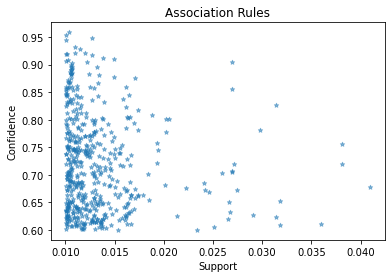

In [29]:
rules.plot.scatter("support", "confidence", alpha=0.5, marker="*")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules")
plt.show()

### Initial Finding

There are not any association rules with both extremly high confidence and extremely high support.

This make sense. If an item set has high support, the items are likely to appear with many other items, making the chances of high confidence very low.

## Conclusion

With this kind of analysis from the field of mareting you can now determine which products are most often bought in combination with each other. With this knowledge it is possible to arrange the products efficiently in the store. In the best case, products that are often bought together are positioned in the opposite direction in the store so that customers are forced to walk past as many other products as possible.

Furthermore, one can now consider targeted discount campaigns. If you discount a product that is often bought in combination with others, you increase the chance of buying these products in combination, whereby a small discount is granted on only one.

References
https://michael-fuchs-python.netlify.app/2020/09/15/marketing-market-basket-analysis/